# Titanic Exercise

Predict who survived the titanic
Dataset from: https://www.kaggle.com/c/titanic/data

**Definitions**

    Variable	Definition	Key
    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation

In [247]:
# Data
import pandas as pd
import math

# SKLearn
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(666)

## Inputs

In [176]:
df = pd.read_csv('data/train.csv')
print df.shape
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Grab test dataframe and test answers

In [177]:
X_test = pd.read_csv('data/test.csv')
y_test = pd.read_csv('data/test-answers.csv')['Survived']

Break dataset into training features and dependent y-vector

In [178]:
y = df.Survived
X = df.drop('Survived', axis=1)

## Investigate Dataset

See if there are any obvious relationships between features and "Survived"

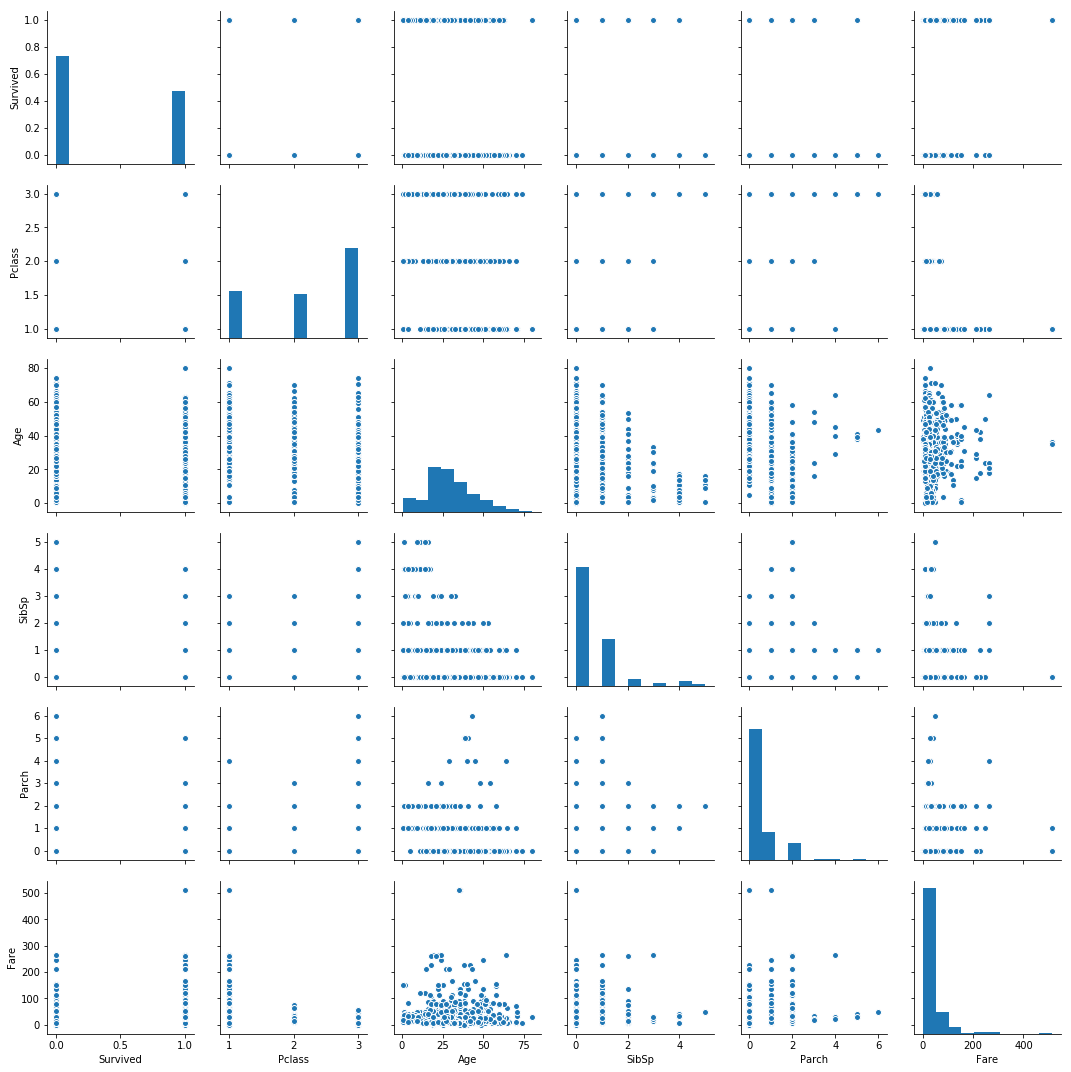

In [179]:
sns.pairplot(df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1).dropna())

No relationships pop out to me that relate to "Survived"

## Preprocess

Which columns have missing data?

In [180]:
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Prepare dataframe by removing uninformative features

In [181]:
X = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

Drop all rows with NaNs -- most ML algorithms won't handle them

In [182]:
X = X.dropna()

Now we'll "One-Hot-Encode" or create "Dummy variables" for our categorical columns

In [183]:
cols_to_encode = ['Sex', 'Embarked', 'Pclass']
X = pd.get_dummies(X, columns = cols_to_encode)
print len(X), 'samples'
X.head()

712 samples


,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


## Linear SVC

[SKLearn recommends](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) an SVM classifier with a **linear** kernel.

In [184]:
clf = SVC()
clf.fit(X, y.iloc[X.index])  # We have to adjust the y-vector because we dropped rows with X.dropna()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [185]:
def prepare_df(df):
    # Drop useless columns
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    # Drop NA rows
    df = df.dropna()
    # One-Hot-Encode categorical features
    cols_to_encode = ['Sex', 'Embarked', 'Pclass']
    return pd.get_dummies(df, columns = cols_to_encode)

In [186]:
X_test = prepare_df(X_test)

In [187]:
clf.score(X_test, y_test.iloc[X_test.index])

0.63746223564954685

## Random Forest

In [188]:
clf = RandomForestClassifier()
clf.fit(X, y.iloc[X.index])
clf.score(X_test, y_test.iloc[X_test.index])

0.83081570996978849

## Gradient Boosting Classifier

In [189]:
clf = GradientBoostingClassifier()
clf.fit(X, y.iloc[X.index])
clf.score(X_test, y_test.iloc[X_test.index])

0.86102719033232633

Which features were most important?

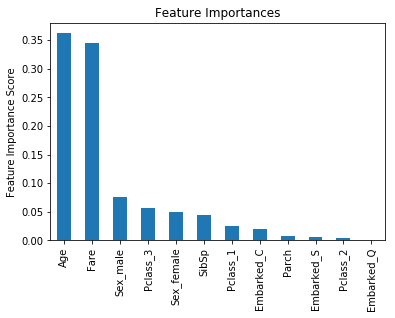

In [190]:
feat_imp = pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Let's drop our uninformative columns and see if that helps

In [200]:
clf = GradientBoostingClassifier()
clf.fit(X.drop(['Embarked_Q', 'Pclass_2', 'Embarked_S'], axis=1), y.iloc[X.index])
clf.score(X_test.drop(['Embarked_Q', 'Pclass_2', 'Embarked_S'], axis=1), y_test.iloc[X_test.index])

0.86706948640483383

## KFold Cross-Validation and Grid Search

Go through classifier parameters using "`sklearn.ensemble.GradientBoostingClassifier?`" and select some ranges after reading the descriptions.

In [211]:
learning_rate = [0.001, 0.01, 0.1, 0.5, 0.9]
n_estimators = [10, 50, 100, 200, 500]
subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
max_depth = [2, 3, 4, 5, 6, 7, 8]
min_samples_split=[2, 7, 10]
min_samples_leaf = [1, 5, 10]
#max_features = 'sqrt'

Create grid search object

In [213]:
gs = GridSearchCV(estimator=GradientBoostingClassifier(max_features='sqrt'), param_grid=dict(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf), scoring='roc_auc', n_jobs=-1, cv=3)

In [215]:
%%time
gs.fit(X, y.iloc[X.index])

CPU times: user 2min 2s, sys: 10.8 s, total: 2min 13s
Wall time: 46min 3s


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_samples_split': [2, 7, 10], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.9], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [217]:
print 'Best params\n{}'.format(gs.best_params_)

Best params
{'learning_rate': 0.5, 'min_samples_leaf': 10, 'n_estimators': 10, 'subsample': 0.8, 'min_samples_split': 10, 'max_depth': 3}


In [218]:
print 'Best score:\n{}'.format(gs.best_score_)

Best score:
0.870926165295


Now let's apply the best parameters and retest

In [223]:
clf = GradientBoostingClassifier(**gs.best_params_)  # Python unpacking trick with kwargs
clf.fit(X, y.iloc[X.index])
clf.score(X_test, y_test.iloc[X_test.index])

0.8429003021148036

Cool! Worse than our unoptimized version, probably due to overfitting. We'll just change subsample since apparently 0.8 is a good default value to use anyway.

In [252]:
clf = GradientBoostingClassifier(subsample=0.8)  # Python unpacking trick with kwargs
clf.fit(X, y.iloc[X.index])
clf.score(X_test, y_test.iloc[X_test.index])

0.88519637462235645

Highst score, but even with a numpy seed the accuracy changes between runs.